This Churn Prediction has been adapted from https://github.com/wildtreetech/ghbd using the dataset provided here: https://www.kaggle.com/filippoo/deep-learning-az-ann.

The purpose of this jupyter-notebook is to demonstrate the importance of precision - recall metric tradeoffs and highlight the use of Receiver Operating Characteristics.

In [38]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

In [39]:
churn_df = pd.read_csv('Churn_Modelling.csv')

In [40]:
churn_df.drop(['RowNumber'], axis = 1, inplace=True)

In [41]:
churn_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [42]:
#churn_df.Geography = churn_df.Geography.astype('category').cat.as_ordered()
#churn_df.Geography = churn_df.Geography.cat.codes+1

In [43]:
y = np.where(churn_df['Exited'] == 1, 1, 0)
print('Fraction of users leaving:', y.mean())

Fraction of users leaving: 0.2037


From above, it is clear that the data shows a churn rate of 20%. We drop columns that are not relevant to our analysis. Also, we need to drop columns that may lead to gender bias. An ethical business does not use gender/race any other discriminatory technique to gain profits.

In [44]:
to_drop = ['Surname', 'CustomerId', 'Geography', 'Exited', 'Gender']
churn_features = churn_df.drop(to_drop, axis=1)

Columns which are categorical are converted to boolean.

In [45]:
yes_no_columns = ['HasCrCard', 'IsActiveMember']
churn_features[yes_no_columns] = churn_features[yes_no_columns] == 1

In [46]:
churn_features.dtypes

CreditScore          int64
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard             bool
IsActiveMember        bool
EstimatedSalary    float64
dtype: object

In [47]:
X = churn_features.as_matrix().astype(np.float)

Here, we initialize 3 classifiers:
1. Dummy Classifier: It's default output is the one which occurs most frquently.
2. K Nearest Neighbors: Using K-Means algorithm, it allots classes.
3. Random Forests: An ensemble method.

50 estimators were ideal to obtain the best possible classification. A maximum depth of 7 is provided for each tree to ensure there is no overfitting. 

Imbalanced classes need to be handled well. class_weight can be provided as a dict with label 0 (no churn) having a weight of 1 and label 1 (churn) having a weight of 5. This is reasonable considering about 20% of the labels in the data are 1. However, one could provid 'balanced' as the value to class_weight and random_forest will automatically weight the data.

The different predictions that might arise are:
1. True Positive (tp) : When the true data is labeled a churn (1) and the classifier predicts a churn (1).
2. False Positive (fp): When the true data is labeled as not a churn (0) and the classifier predicts a churn (1).
3. True Negative (tn) : When the true data is labeled as not a churn (0) and the classifier predicts not a churn (0).
4. False Negative (fn): When the true data is labled as a churn (1) and the classifier predicts a churn (1).

Depending on the need of an application or a business the predictions are given importance:
1. In the case of predicting a churn, the limiting factor in determining predictions is to find out all customers that will churn. This is because in the case of a churn the company loses customers and profits. As a result, the company will give more importance to the recall metric (tp/(tp+fn)). False negatives are incidences of the classifier missing churns. This is also true in the case of predicting cancer. One does not want to forego a checkup if one might have cancer.
2. In the case of credit card fraud detection, if the credit card is blocked upon the detection of a fraudulent transaction, the bank may not want to have a lot of false positives as this is bad for business. Since, the occurrence of fraud is low and the number of transactions are many, the bank does not want to lose out on profits on other transactions. If there is one fraudulent transaction that went undetected, the bank may not suffer much in terms of profits made. However, if many true transactions were marked as fradulent, the bank may lose out on commission on those transactions. Hence, here recall metric is important but there is a dire need to maintain low number of false positives.

In the above situations, it is important to have a tradeoff between precision and recall. F-Beta Score is the metric which takes into consideration the effect of either. A higher beta value places more importance on recall and vice-versa. In the case of churn, we want to emphasize recall or the instance of predicting churn if they occur, we use beta of 1.5.

In [77]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer

f1 = make_scorer(fbeta_score, beta=1.5)

classifiers = [('Dummy', DummyClassifier(strategy='most_frequent')),
               ('RF', RandomForestClassifier(n_estimators=50, max_depth = 7, n_jobs = -1, class_weight = {0: 1, 1: 5},
                                            criterion='entropy')),
               ('kNN', KNeighborsClassifier(n_neighbors= 5,  n_jobs = -1))]

In [78]:
for name,classifier in classifiers:
    cv = StratifiedKFold(y, n_folds=5)
    scores = cross_val_score(classifier, X, y, scoring=f1, cv = cv)
    print(name, 'F-beta_scores:', np.mean(scores))

Dummy F-beta_scores: 0.0
RF F-beta_scores: 0.6144964105739005
kNN F-beta_scores: 0.11265293171474308


In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_predict
import matplotlib.pyplot as plt

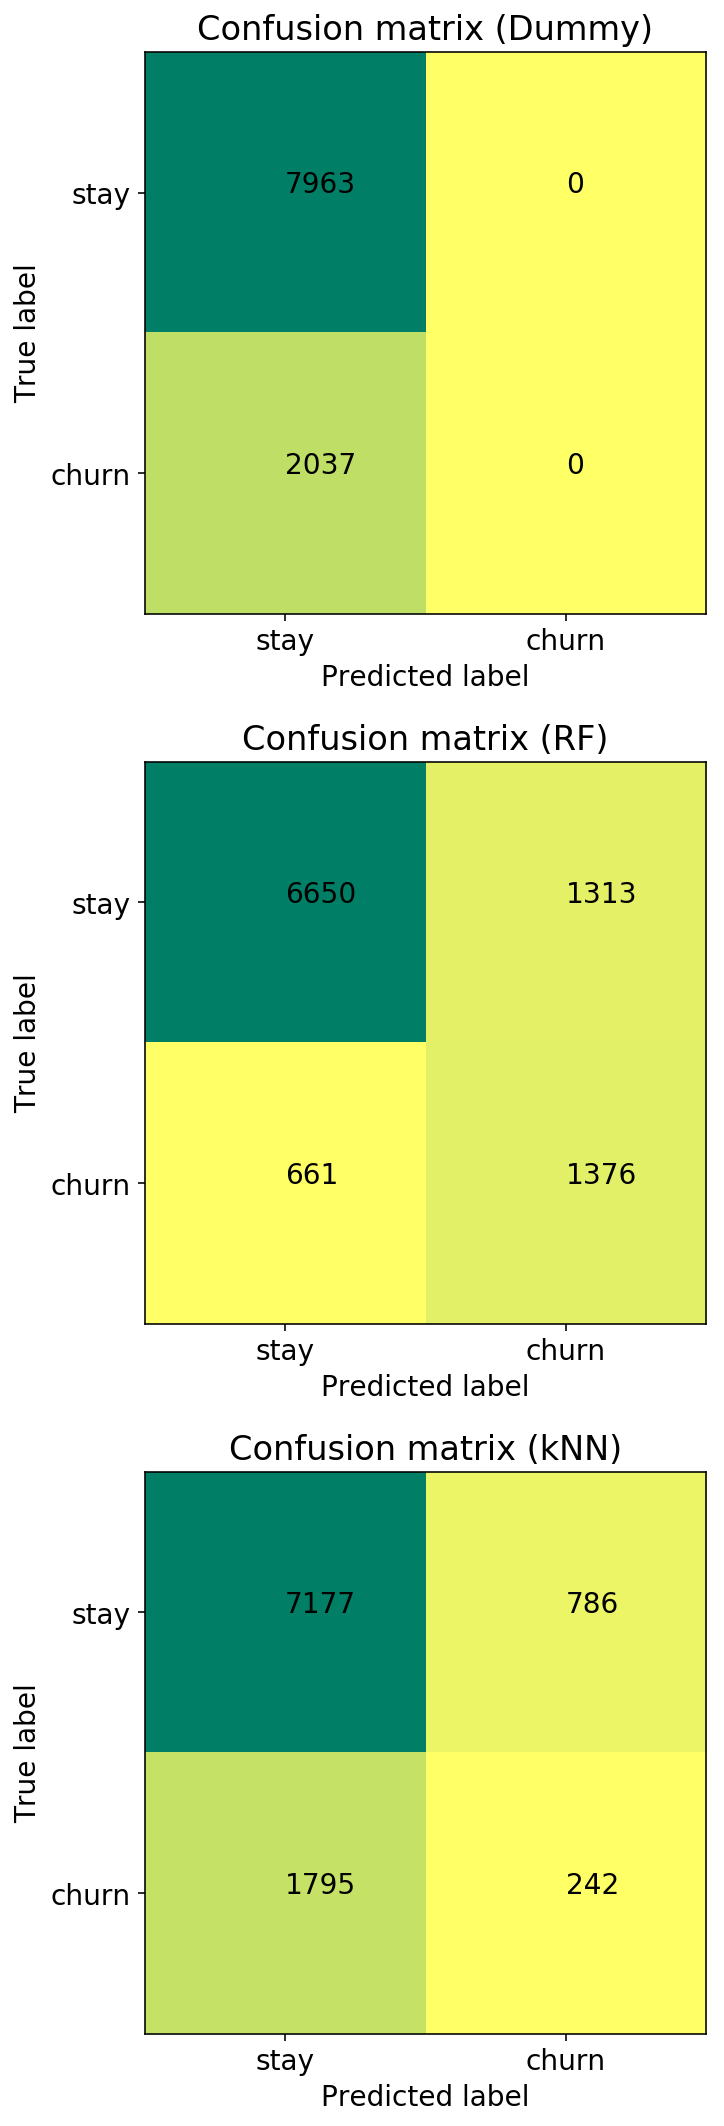

In [76]:
classifiers = [('Dummy', DummyClassifier(strategy='most_frequent')),
               ('RF', RandomForestClassifier(n_estimators=50, max_depth = 7, n_jobs = -1, class_weight = 'balanced',
                                            criterion = 'entropy')),
               ('kNN', KNeighborsClassifier(n_neighbors= 5,  weights = 'distance', n_jobs = -1))]

def plot_confusion_matrix(cm, ax, title='Confusion matrix', cmap=plt.cm.summer_r):
    ax.imshow(cm, interpolation='none', cmap=cmap)

    ax.set_xticks([0,1])
    ax.set_yticks([0,1])

    ax.set_xticklabels(['stay', 'churn'])
    ax.set_yticklabels(['stay', 'churn'])

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.annotate(str(cm[i][j]), xy=(j, i), color='black')

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(title)


fig, axarr = plt.subplots(nrows=len(classifiers), figsize=(5, 5*len(classifiers)))

for (name,classifier), ax in zip(classifiers, axarr):
    cv = StratifiedKFold(y, n_folds=3)
    y_pred = cross_val_predict(classifier, X, y, cv = cv)
    plot_confusion_matrix(confusion_matrix(y, y_pred), ax,
                          'Confusion matrix (%s)'%name)
    
plt.tight_layout()

From the confusion matrix for the three classifiers above, we can easily claim that the RandomForestClassifier has done better. To make any further improvements, we need more features.

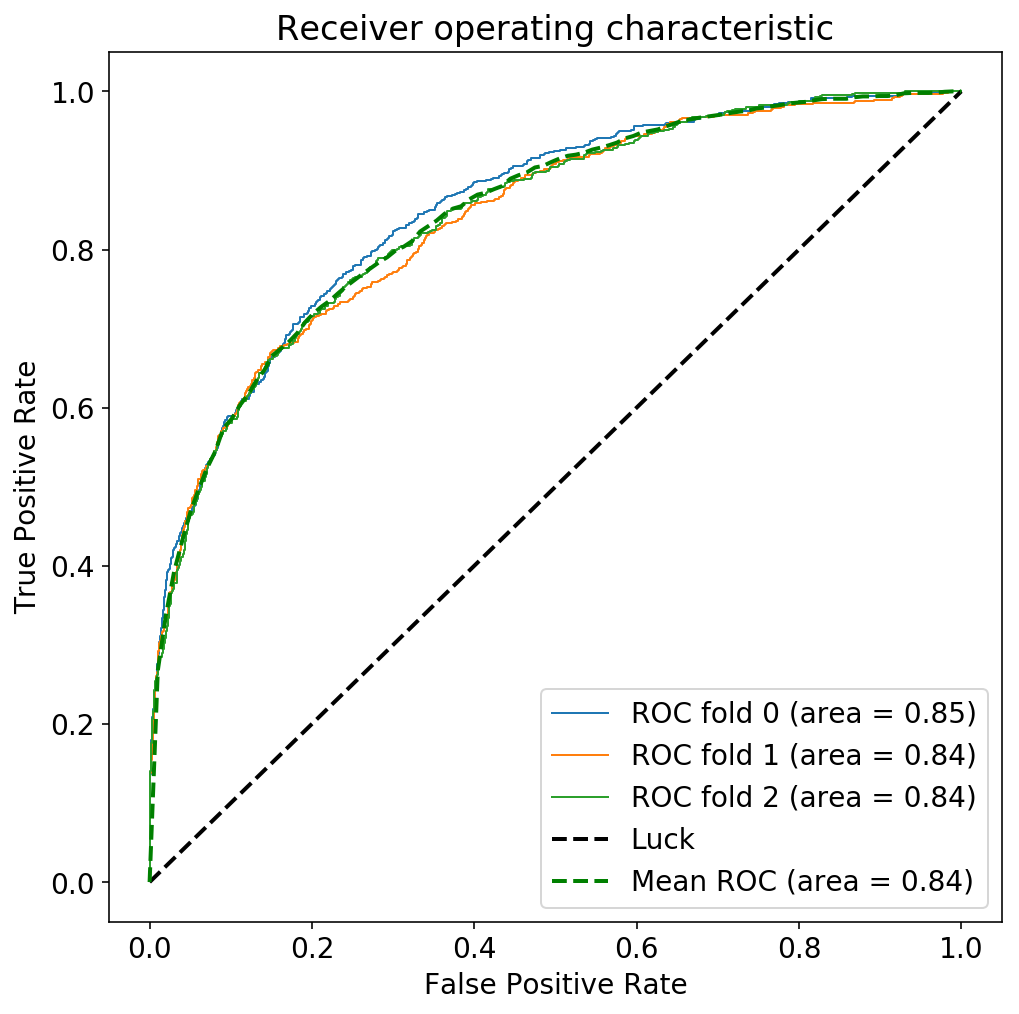

In [75]:
from utils import draw_roc_curve

#clf = RandomForestClassifier()
clf = RandomForestClassifier(n_estimators=100, max_depth = 7, n_jobs = -1, class_weight = 'balanced',
                                            criterion = 'entropy')
#clf = RandomForestClassifier(max_depth=5)
cv = StratifiedKFold(y, n_folds=3)
    
draw_roc_curve(clf, cv, X, y)

Receiver operating characteristic is helpful in determining the effectiveness of a classifier. True positive rate is (tp/(tp+fn)) while false positive rate is (fp/(fp+tn)). Higher the area under this curve, better is the classifier.